# Part 6 - Support Vector Machines (SVM)

**By Aziz Presswala**

In [1]:
# importing libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import find
from tqdm import tqdm
from time import time
from prettytable import PrettyTable

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score

from gensim.models import Word2Vec

### [1.0] Splitting the Dataset into Train & Test

In [2]:
# Using the CleanedText column saved in final.sqlite db
con = sqlite3.connect('final.sqlite')
filtered_data = pd.read_sql_query("SELECT * FROM Reviews", con)
filtered_data.shape

(364171, 12)

In [3]:
# replacing all the 'positive' values of the Score attribute with 1
filtered_data['Score']=filtered_data['Score'].replace('positive',1)

In [4]:
# replacing all the 'neagtive' values of the Score attribute with 0
filtered_data['Score']=filtered_data['Score'].replace('negative',0)

In [5]:
#randomly selecting 100k points from the dataset
df=filtered_data.sample(100000)

In [6]:
#sort the dataset by timestamp
df = df.sort_values('Time')
#splitting the dataset into train(70%) & test(30%)
train_data = df[0:70000]
test_data = df[70000:100000]

In [7]:
#randomly selecting 20k points from the dataset for rbf kernel
df1=filtered_data.sample(20000)

In [8]:
#sort the dataset by timestamp
df1 = df1.sort_values('Time')
#splitting the dataset into train(70%) & test(30%)
train_data_rbf = df1[0:14000]
test_data_rbf = df1[14000:20000]

### [2.0] Featurization

### [2.1] BAG OF WORDS

**For Linear Kernel**

In [9]:
#applying fit transform on train datasset
count_vect = CountVectorizer(min_df=10)
x_train_bow = count_vect.fit_transform(train_data['CleanedText'].values)
x_train_bow.shape

(70000, 7164)

In [10]:
#applying transform on test dataset
x_test_bow = count_vect.transform(test_data['CleanedText'].values)
x_test_bow.shape

(30000, 7164)

In [11]:
y_train_bow = train_data['Score']
y_test_bow = test_data['Score']

**For RBF Kernel**

In [25]:
#applying fit transform on train datasset
count_vect_rbf = CountVectorizer(min_df=10)
x_train_bow_rbf = count_vect_rbf.fit_transform(train_data_rbf['CleanedText'].values)
x_train_bow_rbf.shape

(14000, 3337)

In [26]:
#applying fit transform on test dataset
x_test_bow_rbf = count_vect_rbf.transform(test_data_rbf['CleanedText'].values)
x_test_bow_rbf.shape

(6000, 3337)

In [27]:
y_train_bow_rbf = train_data_rbf['Score']
y_test_bow_rbf = test_data_rbf['Score']

### [2.2] TF-IDF

**For Linear Kernel**

In [18]:
#applying fit transform on train datasset
tf_idf_vect = TfidfVectorizer(min_df=10)
x_train_tfidf = tf_idf_vect.fit_transform(train_data['CleanedText'].values)
x_train_tfidf.shape

(70000, 7164)

In [19]:
#applying transform on test dataset
x_test_tfidf = tf_idf_vect.transform(test_data['CleanedText'].values)
x_test_tfidf.shape

(30000, 7164)

In [20]:
y_train_tfidf = train_data['Score']
y_test_tfidf = test_data['Score']

**For RBF Kernel**

In [31]:
#applying fit transform on train datasset
tf_idf_vect_rbf = TfidfVectorizer(min_df=10)
x_train_tfidf_rbf = tf_idf_vect_rbf.fit_transform(train_data_rbf['CleanedText'].values)
x_train_tfidf_rbf.shape

(14000, 3337)

In [32]:
#applying transform on test dataset
x_test_tfidf_rbf = tf_idf_vect_rbf.transform(test_data_rbf['CleanedText'].values)
x_test_tfidf_rbf.shape

(6000, 3337)

In [33]:
y_train_tfidf_rbf = train_data_rbf['Score']
y_test_tfidf_rbf = test_data_rbf['Score']

### [2.3] Avg. Word2Vec

**For Linear Kernel**

In [34]:
#training Word2Vec Model for train dataset
i=0
list_of_sent=[]
for sent in train_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [35]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [36]:
X = w2v_model[w2v_model.wv.vocab]

In [37]:
#computing Avg Word2Vec for train dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:19<00:00, 500.06it/s]


70000
50


In [38]:
x_train_w2v = np.array(sent_vectors)
y_train_w2v = train_data['Score']
x_train_w2v.shape

(70000, 50)

In [39]:
#training Word2Vec Model for test dataset
i=0
list_of_sent1=[]
for sent in test_data['CleanedText'].values:
    list_of_sent1.append(sent.split())

In [40]:
#computing Avg Word2Vec for test dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:12<00:00, 415.77it/s]


30000
50


In [41]:
x_test_w2v = np.array(sent_vectors)
y_test_w2v = test_data['Score']
x_test_w2v.shape

(30000, 50)

**For RBF Kernel**

In [49]:
#training Word2Vec Model for train dataset
i=0
list_of_sent=[]
for sent in train_data_rbf['CleanedText'].values:
    list_of_sent.append(sent.split())

In [50]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [51]:
X = w2v_model[w2v_model.wv.vocab]

In [52]:
#computing Avg Word2Vec for train dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:19<00:00, 726.18it/s]


14000
50


In [53]:
x_train_w2v_rbf = np.array(sent_vectors)
y_train_w2v_rbf = train_data_rbf['Score']
x_train_w2v_rbf.shape

(14000, 50)

In [54]:
#training Word2Vec Model for test dataset
i=0
list_of_sent1=[]
for sent in test_data_rbf['CleanedText'].values:
    list_of_sent1.append(sent.split())

In [55]:
#computing Avg Word2Vec for test dataset
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:08<00:00, 703.16it/s]


6000
50


In [56]:
x_test_w2v_rbf = np.array(sent_vectors)
y_test_w2v_rbf = test_data_rbf['Score']
x_test_w2v_rbf.shape

(6000, 50)

### [2.4] TFIDF - Word2Vec

**For Linear Kernel**

In [66]:
# training model for training data
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [67]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:48<00:00, 414.90it/s]


In [68]:
x_train_tfw2v = np.array(tfidf_sent_vectors)
y_train_tfw2v = train_data['Score']
x_train_tfw2v.shape

(70000, 50)

In [69]:
# training model for test dataset
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(test_data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [70]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:19<00:00, 377.03it/s]


In [71]:
x_test_tfw2v = np.array(tfidf_sent_vectors)
y_test_tfw2v = test_data['Score']
x_test_tfw2v.shape

(30000, 50)

**For RBF Kernel**

In [72]:
# training model for training data
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(train_data_rbf['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [62]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:24<00:00, 576.98it/s]


In [63]:
x_train_tfw2v_rbf = np.array(tfidf_sent_vectors)
y_train_tfw2v_rbf = train_data_rbf['Score']
x_train_tfw2v_rbf.shape

(14000, 50)

In [64]:
# training model for test dataset
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(test_data_rbf['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [65]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:10<00:00, 554.98it/s]


In [66]:
x_test_tfw2v_rbf = np.array(tfidf_sent_vectors)
y_test_tfw2v_rbf = test_data_rbf['Score']
x_test_tfw2v_rbf.shape

(6000, 50)

### [3.0] Applying SVM

### [3.1] Linear SVM

### [3.1.1] Applying Linear SVM on BOW (l1 reg.),<font color='red'> SET 1</font>

In [12]:
# initializing SGDClassifier model with L1 regularisation
sgdc = SGDClassifier(loss='hinge', penalty='l1', class_weight='balanced')

# alpha values we need to try on classifier
alpha_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'alpha':alpha_values}

# using GridSearchCV to find the optimal value of alpha
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(sgdc,param_grid,scoring='roc_auc',cv=10,return_train_score=True,n_jobs=-1)
gscv.fit(x_train_bow,y_train_bow)

# getting the optimal value of alpha
print("Best alpha Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best alpha Value:  {'alpha': 0.0001}
Best ROC AUC Score: 0.91089


In [13]:
# determining optimal alpha
optimal_alpha = gscv.best_params_['alpha']

# calibrating the above results using CalibratedClassifierCV and training the model
ccv = CalibratedClassifierCV(gscv,cv='prefit')
ccv.fit(x_train_bow,y_train_bow)

#predicting the class label using test data 
y_pred = ccv.predict_proba(x_test_bow)[:,1]

#determining the Test roc_auc_score for optimal alpha
auc_score = roc_auc_score(y_test_bow, y_pred)
print('\n**** Test roc_auc_score for alpha = %f is %f ****' % (optimal_alpha,auc_score))


**** Test roc_auc_score for alpha = 0.000100 is 0.907703 ****


**AUC vs alpha**

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


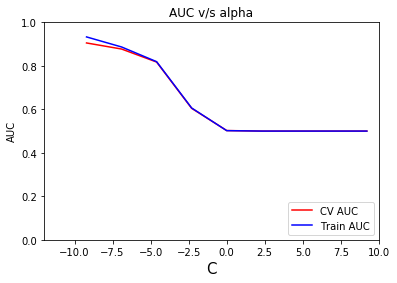

In [14]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in alpha_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s alpha')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[ 2687  2479]
 [  905 23929]]


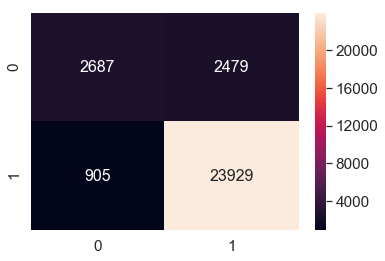

In [15]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_test_bow)
cm = confusion_matrix(y_test_bow, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matrix on Train Data**

[[ 5423  5151]
 [ 1619 57807]]


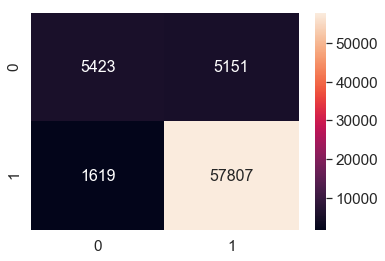

In [16]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_bow)
cm = confusion_matrix(y_train_bow, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**ROC Curve**

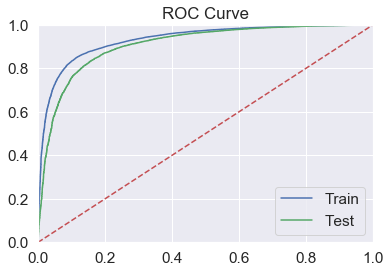

In [17]:
# Plotting roc curve on Train Data
pred_train = ccv.predict_proba(x_train_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_train_bow, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = ccv.predict_proba(x_test_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_test_bow, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### [3.1.2] Applying Linear SVM on BOW (l2 reg.),<font color='red'> SET 1</font>

In [18]:
# initializing SGDClassifier model with L2 regularisation
sgdc = SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced')

# alpha values we need to try on classifier
alpha_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'alpha':alpha_values}

# using GridSearchCV to find the optimal value of alpha
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(sgdc,param_grid,scoring='roc_auc',cv=10,return_train_score=True,n_jobs=-1)
gscv.fit(x_train_bow,y_train_bow)

# getting the optimal value of alpha
print("Best alpha Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best alpha Value:  {'alpha': 0.001}
Best ROC AUC Score: 0.92749


In [19]:
# determining optimal alpha
optimal_alpha = gscv.best_params_['alpha']

# calibrating the above results using CalibratedClassifierCV and training the model
ccv = CalibratedClassifierCV(gscv,cv='prefit')
ccv.fit(x_train_bow,y_train_bow)

#predicting the class label using test data 
y_pred = ccv.predict_proba(x_test_bow)[:,1]

#determining the Test roc_auc_score for optimal alpha
auc_score = roc_auc_score(y_test_bow, y_pred)
print('\n**** Test roc_auc_score for alpha = %.5f is %f ****' % (optimal_alpha,auc_score))


**** Test roc_auc_score for alpha = 0.00100 is 0.931857 ****


**AUC vs alpha**

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


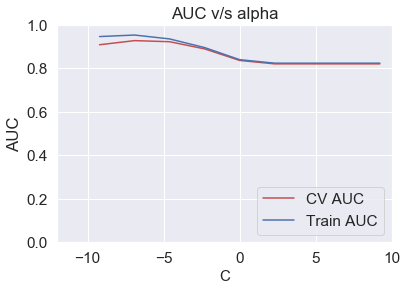

In [20]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in alpha_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s alpha')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[ 3159  2007]
 [  917 23917]]


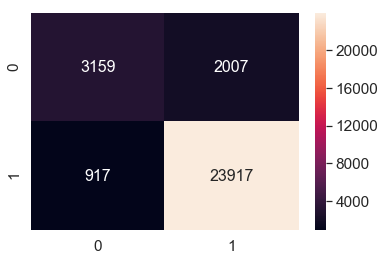

In [21]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_test_bow)
cm = confusion_matrix(y_test_bow, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matrix on Train Data**

[[ 6663  3911]
 [ 1657 57769]]


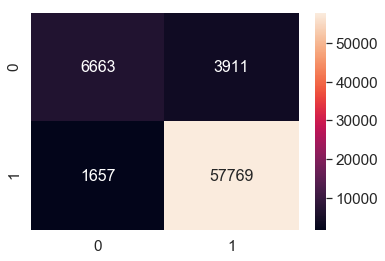

In [22]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_bow)
cm = confusion_matrix(y_train_bow, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**ROC Curve**

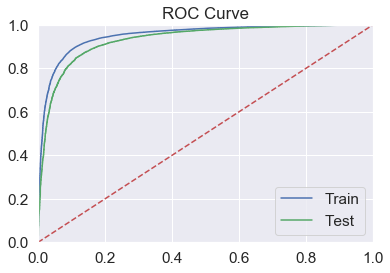

In [23]:
# Plotting roc curve on Train Data
pred_train = ccv.predict_proba(x_train_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_train_bow, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = ccv.predict_proba(x_test_bow)[:,1]
fpr, tpr, threshold = roc_curve(y_test_bow, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### Feature Importance 

In [14]:
# Training the model with optimal alpha value to get the feature importance
clf = SGDClassifier(loss='hinge', penalty='l1', alpha=optimal_alpha)
clf.fit(x_train_bow,y_train_bow)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
feature_names = count_vect.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names),reverse=True)
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\tPositive\t\t\t\tNegative")
print("__________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

		Positive				Negative
__________________________________________________________________________________________________
	47.8184	zevia          				-51.6009	scone          
	29.5217	blast          				-41.3797	worst          
	29.5180	communiti      				-23.4885	aw             
	24.8816	louisiana      				-22.9970	rip            
	24.7078	oro            				-22.7622	terribl        
	24.5689	qualita        				-22.6392	foil           
	24.2616	aerat          				-22.3172	horribl        
	23.4551	addict         				-22.2651	canida         
	22.7108	excel          				-20.7548	lesson         
	22.5032	refresh        				-19.2569	disgust        


### [3.1.3] Applying Linear SVM on TFIDF (l1 reg.),<font color='red'> SET 2</font>

In [21]:
# initializing SGDClassifier model with L1 regularisation
sgdc = SGDClassifier(loss='hinge', penalty='l1', class_weight='balanced')

# alpha values we need to try on classifier
alpha_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'alpha': alpha_values}

# using GridSearchCV to find the optimal value of alpha
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(sgdc,param_grid,scoring='roc_auc',cv=10,return_train_score=True)
gscv.fit(x_train_tfidf,y_train_tfidf)

# getting the optimal value of alpha
print("Best alpha Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best alpha Value:  {'alpha': 0.0001}
Best ROC AUC Score: 0.93541


In [22]:
# determining optimal alpha
optimal_alpha = gscv.best_params_['alpha']

# calibrating the above results using CalibratedClassifierCV and training the model
ccv = CalibratedClassifierCV(gscv,cv='prefit')
ccv.fit(x_train_tfidf,y_train_tfidf)

#predicting the class label using test data 
y_pred = ccv.predict_proba(x_test_tfidf)[:,1]

#determining the Test roc_auc_score for optimal alpha
auc_score = roc_auc_score(y_test_tfidf, y_pred)
print('\n**** Test roc_auc_score for C = %.5f is %f ****' % (optimal_alpha,auc_score))


**** Test roc_auc_score for C = 0.00010 is 0.933137 ****


**AUC vs alpha**

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


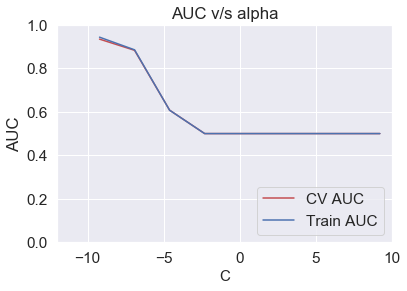

In [31]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in alpha_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s alpha')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[ 3106  2060]
 [  894 23940]]


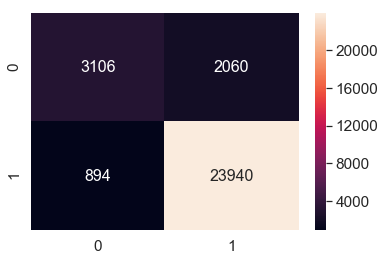

In [32]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_test_tfidf)
cm = confusion_matrix(y_test_tfidf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matrix on Train Data**

[[ 6345  4229]
 [ 1768 57658]]


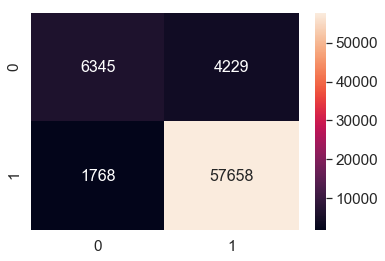

In [33]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_tfidf)
cm = confusion_matrix(y_train_tfidf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**ROC Curve**

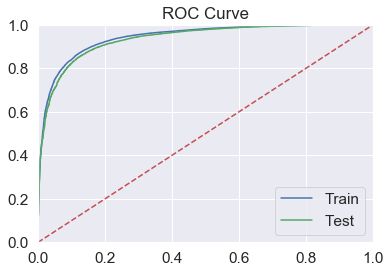

In [34]:
# Plotting roc curve on Train Data
pred_train = ccv.predict_proba(x_train_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfidf, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = ccv.predict_proba(x_test_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### [3.1.4] Applying Linear SVM on TFIDF (l2 reg.),<font color='red'> SET 2</font>

In [18]:
# initializing SGDClassifier model with L2 regularisation
sgdc = SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced')

# alpha values we need to try on classifier
alpha_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'alpha':alpha_values}

# using GridSearchCV to find the optimal value of alpha
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(sgdc,param_grid,scoring='roc_auc',cv=10,return_train_score=True)
gscv.fit(x_train_tfidf,y_train_tfidf)

# getting the optimal value of alpha
print("Best alpha Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best alpha Value:  {'alpha': 0.0001}
Best ROC AUC Score: 0.94330


In [19]:
# determining optimal alpha
optimal_alpha = gscv.best_params_['alpha']

# calibrating the above results using CalibratedClassifierCV and training the model
ccv = CalibratedClassifierCV(gscv,cv='prefit')
ccv.fit(x_train_tfidf,y_train_tfidf)

#predicting the class label using test data 
y_pred = ccv.predict_proba(x_test_tfidf)[:,1]

#determining the Test roc_auc_score for optimal alpha
auc_score = roc_auc_score(y_test_tfidf, y_pred)
print('\n**** Test roc_auc_score for C = %.5f is %f ****' % (optimal_alpha,auc_score))


**** Test roc_auc_score for C = 0.00010 is 0.943233 ****


[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


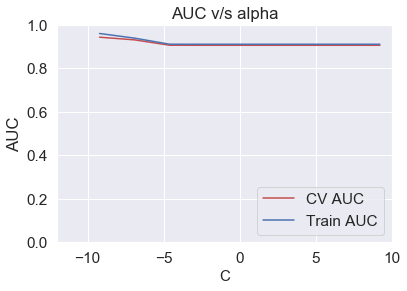

In [20]:
# plotting AUC vs C on Train & Validation dataset
log_alpha=[math.log(x) for x in alpha_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel(r"C",fontsize=15)
plt.ylabel('AUC')
plt.title(r'AUC v/s alpha')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[ 3472  1833]
 [  887 23808]]


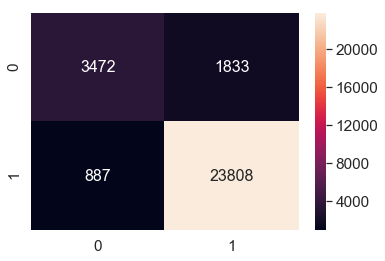

In [21]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_test_tfidf)
cm = confusion_matrix(y_test_tfidf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matrix on Train Data**

[[ 7414  3022]
 [ 1741 57823]]


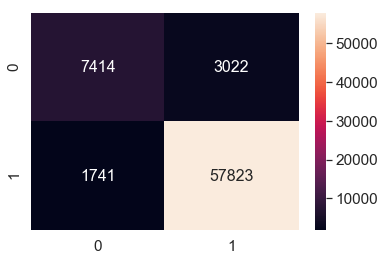

In [22]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_tfidf)
cm = confusion_matrix(y_train_tfidf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**ROC Curve**

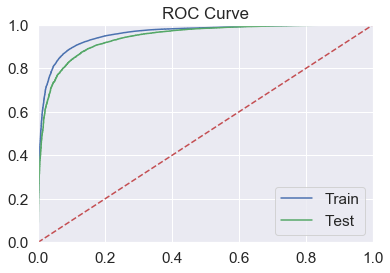

In [23]:
# Plotting roc curve on Train Data
pred_train = ccv.predict_proba(x_train_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_train_tfidf, pred_train)
plt.plot(fpr, tpr, 'b', label='Train')

# Plotting roc curve on Test Data
pred_test = ccv.predict_proba(x_test_tfidf)[:,1]
fpr, tpr, threshold = roc_curve(y_test_tfidf, pred_test)
plt.plot(fpr, tpr, 'g', label='Test')

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

### Feature Importance 

In [23]:
# Training the model with optimal alpha value to get the feature importance
clf = SGDClassifier(loss='hinge', penalty='l1', alpha=optimal_alpha)
clf.fit(x_train_tfidf,y_train_tfidf)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
feature_names = tf_idf_vect.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names),reverse=True)
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\tPositive\t\t\t\tNegative")
print("__________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

		Positive				Negative
__________________________________________________________________________________________________
	5.1297	great          				-8.0417	worst          
	5.0628	delici         				-5.6084	aw             
	4.5153	best           				-5.4433	disappoint     
	3.8739	perfect        				-5.0686	return         
	3.6090	excel          				-5.0151	terribl        
	3.5547	love           				-4.5465	horribl        
	2.8356	amaz           				-4.5168	disgust        
	2.8086	nice           				-4.2374	threw          
	2.6004	good           				-3.8006	gross          
	2.5112	tasti          				-3.7946	wast           


### [3.1.5] Applying Linear SVM on AVG W2V (l1 reg.),<font color='red'> SET 3</font>

In [54]:
# initializing SGDClassifier model with L1 regularisation
sgdc = SGDClassifier(loss='hinge', penalty='l1',class_weights)

# alpha values we need to try on classifier
alpha_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'alpha':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}

# using GridSearchCV to find the optimal value of alpha
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(sgdc,param_grid,scoring='roc_auc',cv=10,return_train_score=True)
gscv.fit(x_train_w2v,y_train_w2v)

# getting the optimal value of alpha
print("Best alpha Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best alpha Value:  {'alpha': 0.001}
Best ROC AUC Score: 0.89904


In [55]:
# determining optimal alpha
optimal_alpha = gscv.best_params_['alpha']

# calibrating the above results using CalibratedClassifierCV and training the model
ccv = CalibratedClassifierCV(gscv,cv='prefit')
ccv.fit(x_train_w2v,y_train_w2v)

#predicting the class label using test data 
y_pred = ccv.predict_proba(x_test_w2v)[:,1]

#determining the Test roc_auc_score for optimal alpha
auc_score = roc_auc_score(y_test_w2v, y_pred)
print('\n**** Test roc_auc_score for C = %.5f is %f ****' % (optimal_alpha,auc_score))


**** Test roc_auc_score for C = 0.00100 is 0.897834 ****


[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


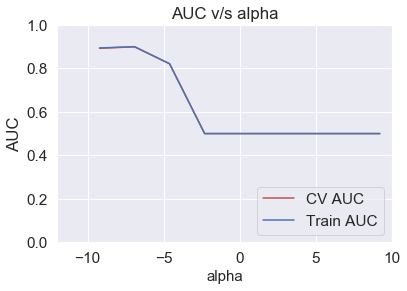

In [56]:
# plotting AUC vs alpha on Train & Validation dataset
log_alpha=[math.log(x) for x in alpha_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel("alpha",fontsize=15)
plt.ylabel('AUC')
plt.title('AUC v/s alpha')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matric on Test Data**

[[ 2423  2826]
 [  858 23893]]


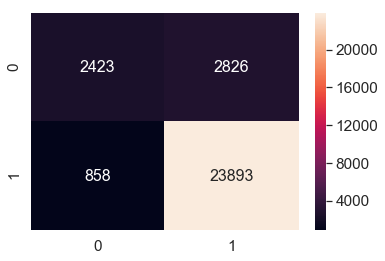

In [57]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_test_w2v)
cm = confusion_matrix(y_test_w2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matric on Train Data**

[[ 4641  5687]
 [ 1749 57923]]


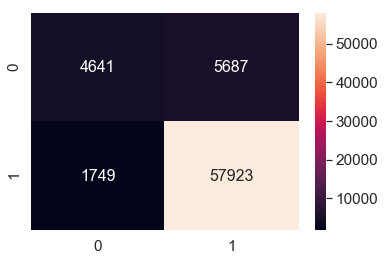

In [59]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_w2v)
cm = confusion_matrix(y_train_w2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [3.1.6] Applying Linear SVM on AVG W2V (l2 reg.),<font color='red'> SET 3</font>

In [60]:
# initializing SGDClassifier model with L2 regularisation
sgdc = SGDClassifier(loss='hinge', penalty='l2')

# alpha values we need to try on classifier
alpha_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'alpha':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}

# using GridSearchCV to find the optimal value of alpha
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(sgdc,param_grid,scoring='roc_auc',cv=10,return_train_score=True)
gscv.fit(x_train_w2v,y_train_w2v)

# getting the optimal value of alpha
print("Best alpha Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best alpha Value:  {'alpha': 0.001}
Best ROC AUC Score: 0.89941


In [61]:
# determining optimal alpha
optimal_alpha = gscv.best_params_['alpha']

# calibrating the above results using CalibratedClassifierCV and training the model
ccv = CalibratedClassifierCV(gscv,cv='prefit')
ccv.fit(x_train_w2v,y_train_w2v)

#predicting the class label using test data 
y_pred = ccv.predict_proba(x_test_w2v)[:,1]

#determining the Test roc_auc_score for optimal alpha
auc_score = roc_auc_score(y_test_w2v, y_pred)
print('\n**** Test roc_auc_score for C = %.5f is %f ****' % (optimal_alpha,auc_score))


**** Test roc_auc_score for C = 0.00100 is 0.899219 ****


[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


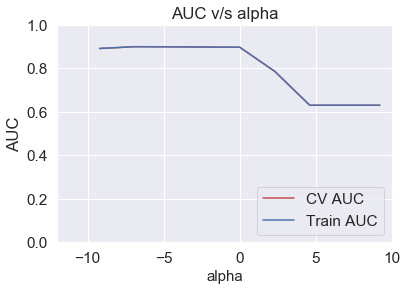

In [62]:
# plotting AUC vs alpha on Train & Validation dataset
log_alpha=[math.log(x) for x in alpha_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel("alpha",fontsize=15)
plt.ylabel('AUC')
plt.title('AUC v/s alpha')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matric on Test Data**

[[ 2456  2793]
 [  849 23902]]


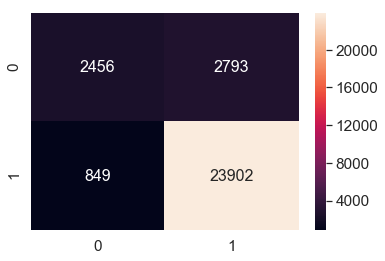

In [63]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_test_w2v)
cm = confusion_matrix(y_test_w2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matric on Train Data**

[[ 4710  5618]
 [ 1760 57912]]


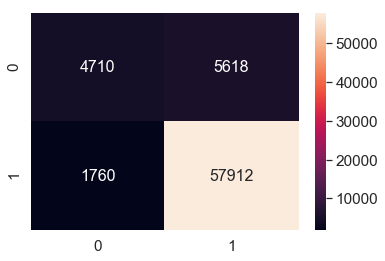

In [64]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_w2v)
cm = confusion_matrix(y_train_w2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [3.1.7] Applying Linear SVM on TFIDF W2V (l1 reg.),<font color='red'> SET 4</font>

In [73]:
# initializing SGDClassifier model with L1 regularisation
sgdc = SGDClassifier(loss='hinge', penalty='l1')

# alpha values we need to try on classifier
alpha_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'alpha':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}

# using GridSearchCV to find the optimal value of alpha
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(sgdc,param_grid,scoring='roc_auc',cv=10,return_train_score=True)
gscv.fit(x_train_tfw2v,y_train_tfw2v)

# getting the optimal value of alpha
print("Best alpha Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best alpha Value:  {'alpha': 0.001}
Best ROC AUC Score: 0.87024


In [74]:
# determining optimal alpha
optimal_alpha = gscv.best_params_['alpha']

# calibrating the above results using CalibratedClassifierCV and training the model
ccv = CalibratedClassifierCV(gscv,cv='prefit')
ccv.fit(x_train_tfw2v,y_train_tfw2v)

#predicting the class label using test data 
y_pred = ccv.predict_proba(x_test_tfw2v)[:,1]

#determining the Test roc_auc_score for optimal alpha
auc_score = roc_auc_score(y_test_tfw2v, y_pred)
print('\n**** Test roc_auc_score for C = %.5f is %f ****' % (optimal_alpha,auc_score))


**** Test roc_auc_score for C = 0.00100 is 0.865229 ****


[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


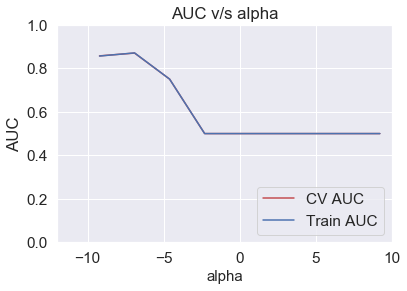

In [75]:
# plotting AUC vs alpha on Train & Validation dataset
log_alpha=[math.log(x) for x in alpha_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel("alpha",fontsize=15)
plt.ylabel('AUC')
plt.title('AUC v/s alpha')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[ 1795  3454]
 [  777 23974]]


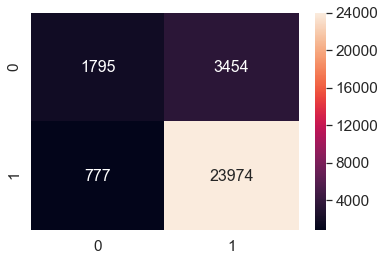

In [76]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_test_tfw2v)
cm = confusion_matrix(y_test_tfw2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matrix on Train Data**

[[ 3515  6813]
 [ 1625 58047]]


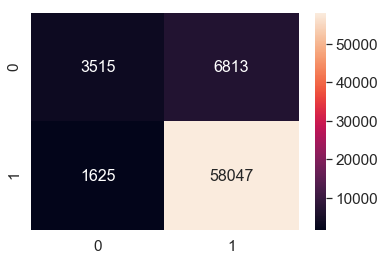

In [77]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_tfw2v)
cm = confusion_matrix(y_train_tfw2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [3.1.8] Applying Linear SVM on TFIDF W2V (l2 reg.),<font color='red'> SET 4</font>

In [78]:
# initializing SGDClassifier model with L2 regularisation
sgdc = SGDClassifier(loss='hinge', penalty='l2')

# alpha values we need to try on classifier
alpha_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'alpha':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}

# using GridSearchCV to find the optimal value of alpha
# using roc_auc as the scoring parameter & applying 10 fold CV
gscv = GridSearchCV(sgdc,param_grid,scoring='roc_auc',cv=10,return_train_score=True)
gscv.fit(x_train_tfw2v,y_train_tfw2v)

# getting the optimal value of alpha
print("Best alpha Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best alpha Value:  {'alpha': 0.001}
Best ROC AUC Score: 0.87182


In [79]:
# determining optimal alpha
optimal_alpha = gscv.best_params_['alpha']

# calibrating the above results using CalibratedClassifierCV and training the model
ccv = CalibratedClassifierCV(gscv,cv='prefit')
ccv.fit(x_train_tfw2v,y_train_tfw2v)

#predicting the class label using test data 
y_pred = ccv.predict_proba(x_test_tfw2v)[:,1]

#determining the Test roc_auc_score for optimal alpha
auc_score = roc_auc_score(y_test_tfw2v, y_pred)
print('\n**** Test roc_auc_score for C = %.5f is %f ****' % (optimal_alpha,auc_score))


**** Test roc_auc_score for C = 0.00100 is 0.866762 ****


[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


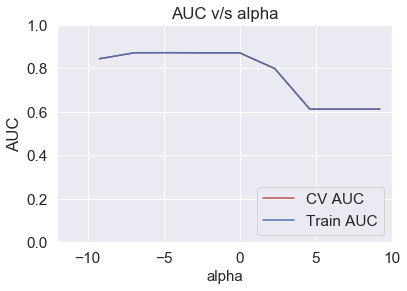

In [80]:
# plotting AUC vs alpha on Train & Validation dataset
log_alpha=[math.log(x) for x in alpha_values]
print(log_alpha)
plt.xlim(-12,10)
plt.ylim(0.0,1.0)
plt.xlabel("alpha",fontsize=15)
plt.ylabel('AUC')
plt.title('AUC v/s alpha')
plt.plot(log_alpha, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_alpha, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[ 1922  3289]
 [  704 24085]]


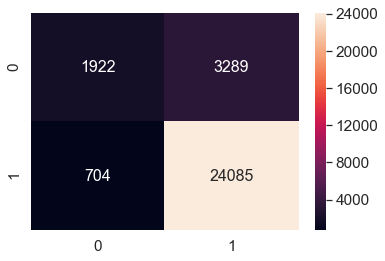

In [101]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_test_tfw2v)
cm = confusion_matrix(y_test_tfw2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matrix on Train Data**

[[ 3549  6779]
 [ 1647 58025]]


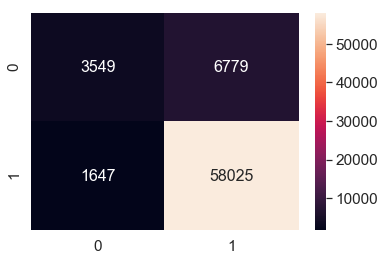

In [81]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_tfw2v)
cm = confusion_matrix(y_train_tfw2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [3.2] RBF SVM

### [3.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [82]:
# initializing SupportVectorClassifier model with RBF Kernel
svc = SVC(kernel='rbf')

# C values we need to try on classifier
C_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter
gscv = GridSearchCV(svc,param_grid,scoring='roc_auc', n_jobs=-1, return_train_score=True)

gscv.fit(x_train_bow_rbf,y_train_bow_rbf)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 100}
Best ROC AUC Score: 0.90546


In [83]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
svc_clf = SVC(kernel='rbf', C=optimal_C, probability=True)
svc_clf.fit(x_train_bow_rbf,y_train_bow_rbf)

#predicting the class label using test data 
y_pred = svc_clf.predict_proba(x_test_bow_rbf)[:,1]

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_bow_rbf, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 100.000000 is 0.918736 ****


**AUC vs C**

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


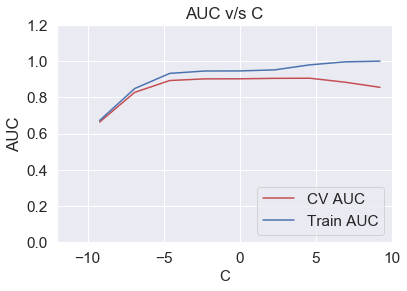

In [84]:
# plotting AUC vs C on Train & Validation dataset
log_C=[math.log(x) for x in C_values]
print(log_C)
plt.xlim(-12,10)
plt.ylim(0.0,1.2)
plt.xlabel("C",fontsize=15)
plt.ylabel('AUC')
plt.title('AUC v/s C')
plt.plot(log_C, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_C, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix on Test Data**

[[ 370  603]
 [ 139 4888]]


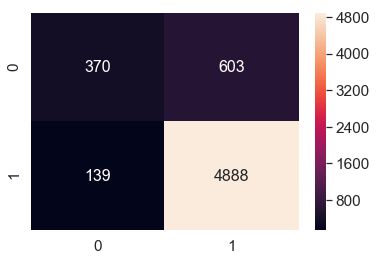

In [43]:
# plotting confusion matrix as heatmap
y_predict = svc_clf.predict(x_test_bow_rbf)
cm = confusion_matrix(y_test_bow_rbf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

**Confusion Matrix on Train Data**

[[ 3549  6779]
 [ 1647 58025]]


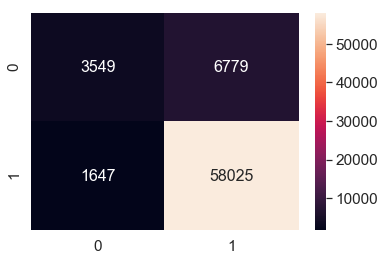

In [85]:
# plotting confusion matrix as heatmap
y_predict = ccv.predict(x_train_tfw2v)
cm = confusion_matrix(y_train_tfw2v, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [3.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [44]:
# initializing SupportVectorClassifier model with RBF Kernel
svc = SVC(kernel='rbf')

# C values we need to try on classifier
C_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter
gscv = GridSearchCV(svc, param_grid, scoring='roc_auc', n_jobs=-1, return_train_score=True)

gscv.fit(x_train_tfidf_rbf,y_train_tfidf_rbf)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 100}
Best ROC AUC Score: 0.88825


In [45]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
svc_clf = SVC(kernel='rbf', C=optimal_C, probability=True)
svc_clf.fit(x_train_tfidf_rbf,y_train_tfidf_rbf)

#predicting the class label using test data 
y_pred = svc_clf.predict_proba(x_test_tfidf_rbf)[:,1]

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_tfidf_rbf, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 100.000000 is 0.888614 ****


**AUC vs C**

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


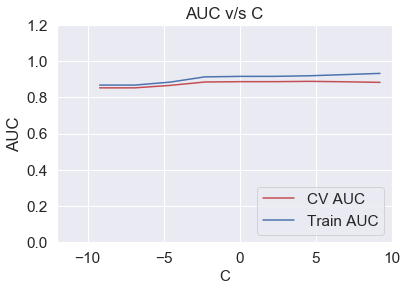

In [46]:
# plotting AUC vs C on Train & Validation dataset
log_C=[math.log(x) for x in C_values]
print(log_C)
plt.xlim(-12,10)
plt.ylim(0.0,1.2)
plt.xlabel("C",fontsize=15)
plt.ylabel('AUC')
plt.title('AUC v/s C')
plt.plot(log_C, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_C, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix**

[[ 311  662]
 [  77 4950]]


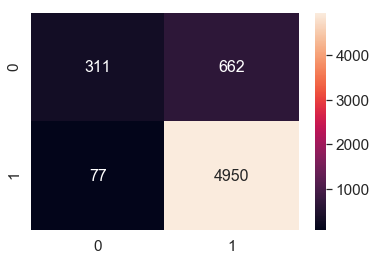

In [47]:
# plotting confusion matrix as heatmap
y_predict = svc_clf.predict(x_test_tfidf_rbf)
cm = confusion_matrix(y_test_tfidf_rbf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [3.2.3] Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [57]:
# initializing SupportVectorClassifier model with RBF Kernel
svc = SVC(kernel='rbf')

# C values we need to try on classifier
C_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter
gscv = GridSearchCV(svc, param_grid, scoring='roc_auc', n_jobs=-1, return_train_score=True)

gscv.fit(x_train_w2v_rbf,y_train_w2v_rbf)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 10}
Best ROC AUC Score: 0.87154


In [58]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
svc_clf = SVC(kernel='rbf', C=optimal_C, probability=True)
svc_clf.fit(x_train_w2v_rbf,y_train_w2v_rbf)

#predicting the class label using test data 
y_pred = svc_clf.predict_proba(x_test_w2v_rbf)[:,1]

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_w2v_rbf, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 10.000000 is 0.863734 ****


**AUC vs C**

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


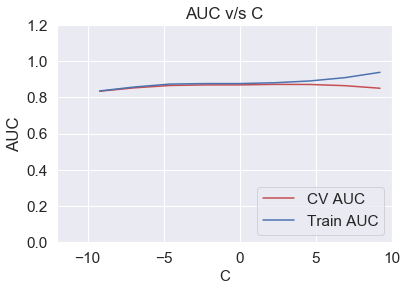

In [59]:
# plotting AUC vs C on Train & Validation dataset
log_C=[math.log(x) for x in C_values]
print(log_C)
plt.xlim(-12,10)
plt.ylim(0.0,1.2)
plt.xlabel("C",fontsize=15)
plt.ylabel('AUC')
plt.title('AUC v/s C')
plt.plot(log_C, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_C, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix**

[[ 163  810]
 [  45 4982]]


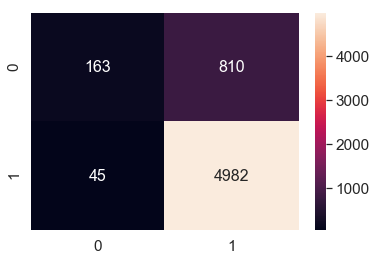

In [60]:
# plotting confusion matrix as heatmap
y_predict = svc_clf.predict(x_test_w2v_rbf)
cm = confusion_matrix(y_test_w2v_rbf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [3.2.4] Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [68]:
# initializing SupportVectorClassifier model with RBF Kernel
svc = SVC(kernel='rbf')

# C values we need to try on classifier
C_values = [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]
param_grid = {'C':[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}

# using GridSearchCV to find the optimal value of C
# using roc_auc as the scoring parameter
gscv = GridSearchCV(svc, param_grid, scoring='roc_auc', n_jobs=-1, return_train_score=True)

gscv.fit(x_train_tfw2v_rbf,y_train_tfw2v_rbf)

print("Best C Value: ",gscv.best_params_)
print("Best ROC AUC Score: %.5f"%(gscv.best_score_))

Best C Value:  {'C': 10}
Best ROC AUC Score: 0.84562


In [69]:
# determining optimal C
optimal_C = gscv.best_params_['C']

#training the model using the optimal C
svc_clf = SVC(kernel='rbf', C=optimal_C, probability=True)
svc_clf.fit(x_train_tfw2v_rbf,y_train_tfw2v_rbf)

#predicting the class label using test data 
y_pred = svc_clf.predict_proba(x_test_tfw2v_rbf)[:,1]

#determining the Test roc_auc_score for optimal C
auc_score = roc_auc_score(y_test_tfw2v_rbf, y_pred)
print('\n**** Test roc_auc_score for C = %f is %f ****' % (optimal_C,auc_score))


**** Test roc_auc_score for C = 10.000000 is 0.840449 ****


**AUC vs C**

[-9.210340371976182, -6.907755278982137, -4.605170185988091, -2.3025850929940455, 0.0, 2.302585092994046, 4.605170185988092, 6.907755278982137, 9.210340371976184]


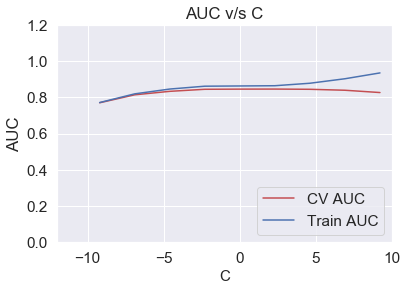

In [70]:
# plotting AUC vs C on Train & Validation dataset
log_C=[math.log(x) for x in C_values]
print(log_C)
plt.xlim(-12,10)
plt.ylim(0.0,1.2)
plt.xlabel("C",fontsize=15)
plt.ylabel('AUC')
plt.title('AUC v/s C')
plt.plot(log_C, gscv.cv_results_['mean_test_score'], 'r', label='CV AUC')
plt.plot(log_C, gscv.cv_results_['mean_train_score'], 'b', label='Train AUC')
plt.legend(loc='lower right')
plt.show()

**Confusion Matrix**

[[  25  948]
 [  13 5014]]


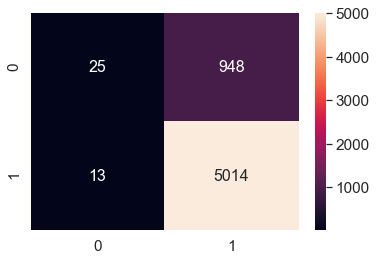

In [71]:
# plotting confusion matrix as heatmap
y_predict = svc_clf.predict(x_test_tfw2v_rbf)
cm = confusion_matrix(y_test_tfw2v_rbf, y_predict)
print(cm)
df_cm = pd.DataFrame(cm, range(2),range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [4.0] Conclusion

In [37]:
# Summarizing the observations
x=PrettyTable()
x.field_names = ['Vectorizer', 'Regularizer', 'Alpha', 'Train AUC', 'Test AUC']
x.add_row(['BOW', 'l1', '0.0001', '0.90528', '0.90802'])
x.add_row(['BOW', 'l2', '0.001', '0.92749', '0.93185'])
x.add_row(['TFIDF', 'l1', '0.0001', '0.93440', '0.93586'])
x.add_row(['TFIDF', 'l2', '0.0001', '0.94330', '0.94323'])
x.add_row(['Avg W2V', 'l1', '0.001', '0.89904', '0.90300'])
x.add_row(['Avg W2V', 'l2', '0.001', '0.89941', '0.90357'])
x.add_row(['TFIDF-W2V', 'l1', '0.001', '0.87024', '0.87130'])
x.add_row(['TFIDF-W2V', 'l2', '0.01', '0.87182', '0.87173'])
print('***** Observations for Linear SVM *****')
print(x)

***** Observations for Linear SVM *****
+------------+-------------+--------+-----------+----------+
| Vectorizer | Regularizer | Alpha  | Train AUC | Test AUC |
+------------+-------------+--------+-----------+----------+
|    BOW     |      l1     | 0.0001 |  0.90528  | 0.90802  |
|    BOW     |      l2     | 0.001  |  0.92749  | 0.93185  |
|   TFIDF    |      l1     | 0.0001 |  0.93440  | 0.93586  |
|   TFIDF    |      l2     | 0.0001 |  0.94330  | 0.94323  |
|  Avg W2V   |      l1     | 0.001  |  0.89904  | 0.90300  |
|  Avg W2V   |      l2     | 0.001  |  0.89941  | 0.90357  |
| TFIDF-W2V  |      l1     | 0.001  |  0.87024  | 0.87130  |
| TFIDF-W2V  |      l2     |  0.01  |  0.87182  | 0.87173  |
+------------+-------------+--------+-----------+----------+


From the above table, we can draw the following conclusions:-
1. Bag of Words (BoW) & TFIDF Vectorizer perform better as compared to Avg Word2Vec & TFIDF Word2Vec.
2. Models trained with L2 regularization perform better than L1 regularization.

In [38]:
x=PrettyTable()
x.field_names = ['Vectorizer', 'C', 'Train AUC', 'Test AUC']
x.add_row(['BOW', '10', '0.90546', '0.88696'])
x.add_row(['TFIDF', '100', '0.88825', '0.88861'])
x.add_row(['Avg W2V', '10', '0.87154', '0.86373'])
x.add_row(['TFIDF-W2V', '10', '0.84562', '0.84044'])
print('*** Observations for RBF SVM ***')
print(x)

*** Observations for RBF SVM ***
+------------+-----+-----------+----------+
| Vectorizer |  C  | Train AUC | Test AUC |
+------------+-----+-----------+----------+
|    BOW     |  10 |  0.90546  | 0.88696  |
|   TFIDF    | 100 |  0.88825  | 0.88861  |
|  Avg W2V   |  10 |  0.87154  | 0.86373  |
| TFIDF-W2V  |  10 |  0.84562  | 0.84044  |
+------------+-----+-----------+----------+


From the above table, we can draw the following conclusions:-
1. Bag of Words (BoW) & TFIDF Vectorizer perform better as compared to Avg Word2Vec & TFIDF Word2Vec.
2. SVM using RBF Kernels have a significantly high training time as compared to Linear SVM's